In [65]:
bbox = [115.179, -8.734, 115.183, -8.729 ]

x_min = bbox[0]
x_max = bbox[2]
y_min = bbox[1]
y_max = bbox[3]


file_name = 'Situ_Denpasar_harbor_no_acomp.tif'

  taken on 2020-02-23T02:43:28.850Z


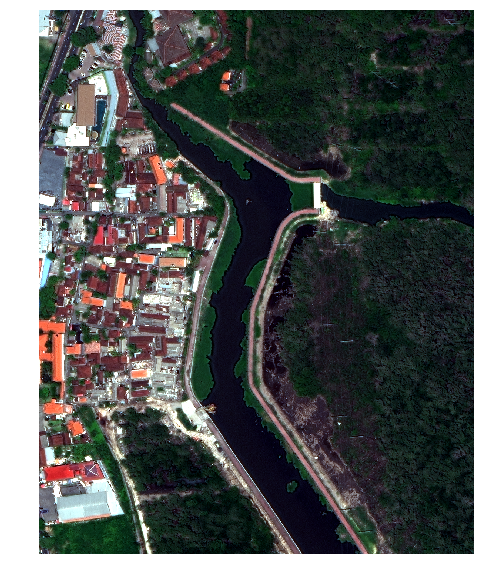

'Situ_Denpasar_harbor_no_acomp.tif'

In [66]:
# Import image and convert image to UTM projection

from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline



catalog_id = env.inputs.get('catalog_id', '104001005876CA00')





# get a projected coordinate system for plotting
EPSG = 32700-round((45+list(bbox)[1])/90,0)*100+round((183+list(bbox)[0])/6,0)
UTM_EPSG_code ='EPSG:%i'  % (EPSG)

image = CatalogImage(catalog_id, band_type="MS", bbox=bbox, pansharpen = True, acomp=False)

acquisitionDate = image.metadata["image"]["acquisitionDate"]

print("  taken on {}".format(acquisitionDate))


image.plot(w=10, h=10)

# Transform dask array to array
image_array = image.read()
data = image_array

image.geotiff(path=file_name)

In [59]:
# install 
!pip install fiona folium

# load libraries
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import Point
from shapely.geometry import shape

import fiona

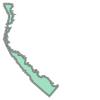

In [78]:
# load polygons
path = 'shapes/Denpasar_port_water.shp'
shape_crs = fiona.open(path)
water_Multi = MultiPolygon([shape(pol['geometry']) for pol in fiona.open(path)]) 

min_x, min_y, max_x, max_y = water_Multi.bounds

water_Multi

In [79]:
UTM_EPSG_code

'EPSG:32750'

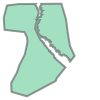

In [80]:
# load polygons
path = 'shapes/Denpasar_port_nonwater.shp'
shape_crs = fiona.open(path)
non_water_Multi = MultiPolygon([shape(pol['geometry']) for pol in fiona.open(path)]) 

min_x, min_y, max_x, max_y = non_water_Multi.bounds

non_water_Multi

In [81]:
def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds

    points = []

    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)

    return points

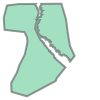

In [82]:
from shapely.ops import transform
from functools import partial
import pyproj

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:4326'))


non_water_Multi_wgs = transform(project, non_water_Multi)
water_Multi_wgs = transform(project, water_Multi)

non_water_Multi_wgs

In [83]:
import random

n_points = 100

points_water = random_points_within(water_Multi_wgs, n_points)

points_non_water = random_points_within(non_water_Multi_wgs, n_points)

In [84]:
## check data!!
# !pip install folium


import folium


m = folium.Map([water_Multi_wgs.centroid.y, water_Multi_wgs.centroid.x],  zoom_start = 16, 
               tiles = 'https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
              attr='CartoDB', name = 'cartocdn')

folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',attr='esri', name = 'esri Imagery').add_to(m)


# folium.raster_layers.ImageOverlay(
#     image=image.rgb(),
#     name='image 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,0,0, x)
# ).add_to(m)

# folium.raster_layers.ImageOverlay(
#     image=classification_plot,
#     name='Classification 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,x,x, 1)
# ).add_to(m)


folium.Choropleth(Multi_wgs, name = 'Training set water').add_to(m)

folium.Choropleth(non_water_Multi_wgs, name = 'Training set water').add_to(m)


# folium.Choropleth(setu_smooth, name = 'Smooth setu delineation').add_to(m)



# f_smooth = [0.00001,0.00002,0.00003,0.00004,0.00006,0.00008]

# for i in f_smooth:
#     setu_smooth = setu_wgs.simplify(i)
#     folium.Choropleth(setu_smooth, name = 'smooth setu delineation'.format(i)).add_to(m)
# # 


# I can add marker one by one on the map
# for i in range(0,len(data)):
#     folium.Marker([data.iloc[i]['lon'], data.iloc[i]['lat']], popup=data.iloc[i]['name']).add_to(m)

for point in points_water:
    #point_wgs = transform(project, point)
    folium.Marker([point.y, point.x], name = 'water').add_to(m)
    
    
for point in points_non_water:
    #point_wgs = transform(project, point)
    folium.Marker([point.y, point.x], name = 'non_water').add_to(m)

folium.LayerControl().add_to(m)

m

In [85]:
def get_values_for_points(dataset, points):

    bands_save = []
    x_save = []
    y_save = []
    
    data_array = dataset.read()

    for i in range(n_points):
        x = points[i].x
        y = points[i].y

        x_save.append(x)
        y_save.append(y)

        index = dataset.index(x, y)

        band_values = data_array[:,index[0],index[1]]

        bands_save.append(band_values)

#         print(band_values)
        
    return bands_save, x_save, y_save

In [87]:
import rasterio

dataset = rasterio.open(file_name)



In [88]:
bands_save, x_save, y_save = get_values_for_points(dataset, points_water)

bands_save_n, x_save_n, y_save_n = get_values_for_points(dataset, points_non_water)

In [89]:
# Create dataframe from clicked values

import pandas as pd

df_bands = pd.DataFrame(bands_save)

df_bands['x'] = x_save
df_bands['y'] = y_save
df_bands['label'] = 'water'

In [90]:
df_bands_n = pd.DataFrame(bands_save_n)

df_bands_n['x'] = x_save_n
df_bands_n['y'] = y_save_n
df_bands_n['label'] = 'non_water'

In [91]:
frames = [df_bands, df_bands_n]

#concatenate dataframes
df = pd.concat(frames, sort=False)

In [92]:
df.sample(10)

,0,1,2,3,4,5,6,7,x,y,label
56,1642.0,1230.0,976.0,818.0,732.0,626.0,631.0,481.0,115.180452,-8.730318,water
31,1629.0,1226.0,1021.0,856.0,761.0,946.0,1337.0,899.0,115.179894,-8.729151,water
60,1690.0,1274.0,1043.0,879.0,782.0,845.0,1051.0,738.0,115.179902,-8.729152,water
37,1680.0,1274.0,1053.0,927.0,865.0,754.0,847.0,568.0,115.180358,-8.730349,water
23,1560.0,1199.0,998.0,854.0,773.0,895.0,1185.0,928.0,115.179904,-8.729272,water
64,1702.0,1275.0,1017.0,848.0,768.0,662.0,710.0,527.0,115.180392,-8.730247,water
61,2215.0,1742.0,1485.0,1875.0,2316.0,2466.0,2848.0,2117.0,115.179522,-8.731091,non_water
12,1578.0,1196.0,950.0,786.0,721.0,584.0,608.0,439.0,115.180616,-8.730521,water
10,1736.0,1304.0,1036.0,870.0,789.0,685.0,736.0,551.0,115.180302,-8.730152,water
1,1463.0,1127.0,1092.0,1061.0,1020.0,1569.0,2389.0,1920.0,115.180290,-8.730497,non_water


In [93]:
import datetime

NOW = datetime.datetime.now()

csv_filename = "data_non_acomp_{}_{}.csv".format(file_name, NOW)

df.to_csv(csv_filename)

print(csv_filename)

data_non_acomp_Situ_Denpasar_harbor_no_acomp.tif_2020-03-02 07:17:53.829685.csv


# In case of emergency

In [54]:
# Save dataframe as csv file and create download link
from IPython.display import HTML
import base64  
import pandas as pd  
import datetime

NOW = datetime.datetime.now()

def create_download_link(df, title = "Download CSV file", 
                         filename = "data_{}_{}.csv".format(file_name, NOW)):  
    
    csv = df.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df)